<img src="img/banniere.jpg" />

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Import des donnees:
data = pd.read_csv("datas/billets_complet.csv", sep = ',')

In [3]:
data["is_genuine"].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [4]:
y = data["is_genuine"]
x = data.drop("is_genuine", axis = 1)
X_train, X_test, y_train, y_test  = train_test_split(x, 
                                                     y, 
                                                     test_size=0.25, 
                                                     random_state=42)

In [5]:
modele_rf = RandomForestClassifier(
     n_estimators=100,
     criterion='gini',
     max_depth=None,
     min_samples_split=2,
     min_samples_leaf=1,
     min_weight_fraction_leaf=0.0,
     max_features='auto',
     max_leaf_nodes=None,
     min_impurity_decrease=0.0,
     bootstrap=True,
     oob_score=False,
     n_jobs=None,
     random_state=None,
     verbose=0,
     warm_start=False,
     class_weight=None,
     ccp_alpha=0.0,
     max_samples=None,)

In [6]:
modele_rf.fit(X_train, y_train)

RandomForestClassifier()

In [7]:
pd.DataFrame(modele_rf.feature_importances_,
              index = X_train.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
length,0.443561
margin_low,0.308258
margin_up,0.125608
height_right,0.075753
height_left,0.037856
diagonal,0.008964


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, modele_rf.predict(X_test))*100} %")

Le pourcentage de bien classés est de : 99.2 %


In [9]:
pd.DataFrame(confusion_matrix(y_test, modele_rf.predict(X_test)),
             index = ['faux données','vrai données'],
             columns = ['Faux predits','Vrai predit'])

,Faux predits,Vrai predit
faux données,132,3
vrai données,0,240


In [10]:
def plot_confusion_matrix(cf_matrix):
    plt.figure(figsize=(7, 7))
    ['False Pos','True Pos','True Neg','False Neg']
    group_names = ['True Negative','False Negative','False Positive','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title("Prédiction avec les données normalisées")
    plt.show()

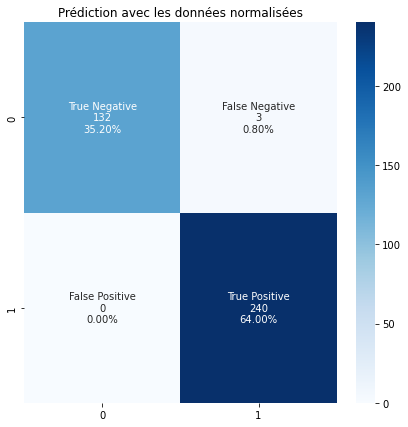

In [11]:
res = confusion_matrix(y_test, modele_rf.predict(X_test))
plot_confusion_matrix(res)

# Test sur echantillon

In [12]:
#import des données test
new = pd.read_csv("datas/billets_production.csv")

In [13]:
# Variables explicatives
X_new = new.drop(columns='id')

std_scale = preprocessing.StandardScaler().fit(X_new)
X_scaled = std_scale.transform(X_new)

In [14]:
y_pred_new = modele_rf.predict(X_new)
# On ajoute le resutat dans un colonne
new["Prediction"] = y_pred_new
# Calcul des probabilités d'appartenir à une classe
proba_new = modele_rf.predict_proba(X_new)
new['Proba_Faux'] = proba_new[:,0].round(4)*100
new['Proba_Vrai'] = proba_new[:,1].round(4)*100

In [15]:
new.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prediction,Proba_Faux,Proba_Vrai
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,95.0,5.0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,100.0,0.0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,100.0,0.0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,4.0,96.0
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,0.0,100.0


In [16]:
for j, i, k in zip(new.index, new["Prediction"], new["id"]):
    if i == True : 
       print("Le billet {}".format(k),"semble vrai avec une probabilité de "
             + str(new.iloc[j,9]),"%")
    else : 
        print("Le billet {}".format(k),"semble faux ""semble faux avec une probabilité de "
             + str(new.iloc[j,8]),"%")

Le billet A_1 semble faux semble faux avec une probabilité de 95.0 %
Le billet A_2 semble faux semble faux avec une probabilité de 100.0 %
Le billet A_3 semble faux semble faux avec une probabilité de 100.0 %
Le billet A_4 semble vrai avec une probabilité de 96.0 %
Le billet A_5 semble vrai avec une probabilité de 100.0 %


In [17]:
# export
new.to_csv('resultats/monmodel_RF.csv',index=False)